# Weather and Commodities

With the current climate change already witnessed globally by the rising air and water temperatures, loss of sea ice and flooding due to melting of the Greenland ice sheet, has heightened my curiosity on the extent of these phenomenon on the agricultural commodities' supply hence pricing. I come from Kenya, a third word country in the sub-saharan Africa still facing harsh effects during periods of severe famine and drought. The economy still has agriculture as one of its top four pillars of development and growth hence highly sensitive to the effects brought forth buy weather shocks both at the consumer-level and country-level. I've been interested in the environment and our interactions with it for most part of my life. This study examines the relationship between weather and agricultural commodities prices. Specifically, can we use recent weather to predict prices in the near future? Corn, cotton, and wheat are three of the US' biggest crops (here, due to availability of the data) and we have corn, millet, sorghum (for Kenya). The hypothesis is that continued weather shocks, brought about by the climate change that we've begun to feel, will affect the supply of these commodities when they hit the market in the near future. This reduced supply would then drive food prices up. I will use US spot prices and US weather data (still working on getting the Kenyan weather data). This analysis assumes that the US market is the driver of US commodity prices; as three of the US largest crops, they certainly have a large effect on domestic prices. However, it is certainly possible that imports from other countries would affect prices too.

### Imports

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

% matplotlib inline

### Commodities Data

In [5]:
data = pd.read_csv('./price-data.csv', header=0)
data['date'] = pd.to_datetime(data.date)
print(data.shape)

(10834, 4)


In [6]:
data.head()

,date,wheat_price,corn_price,cotton_price
0,1975-04-04,3.8225,3.0550,0.413
1,1975-04-07,3.7750,3.0675,0.418
2,1975-04-08,3.7725,3.0550,0.415
3,1975-04-09,3.7825,3.0550,0.413
4,1975-04-10,3.6525,2.9500,0.410


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
wheat_price,10834.0,3.984247,1.399714,1.935,3.098125,3.635,4.36,11.945
corn_price,10834.0,3.006277,1.277517,1.220,2.215000,2.620,3.47,8.490
cotton_price,10834.0,0.653840,0.184056,0.263,0.549000,0.630,0.73,2.106


In [8]:
def recession(x):   #take into account the recessions in the US throughout the  study period
    if x > pd.datetime(1975,1,1) and x < pd.datetime(1975,3,31):
        return 1
    if x > pd.datetime(1979,3,31) and x < pd.datetime(1980,6,30):
        return 1
    if x > pd.datetime(1981,3,31) and x < pd.datetime(1982,6,30):
        return 1
    if x > pd.datetime(1989,9,30) and x < pd.datetime(1991,3,31):
        return 1
    if x > pd.datetime(2001,1,1) and x < pd.datetime(2001,9,30):
        return 1
    if x > pd.datetime(2007,9,30) and x < pd.datetime(2009,6,3):
        return 1
    else:
        return 0 

In [9]:
data['recession'] = data.date.map(lambda x: recession(x))

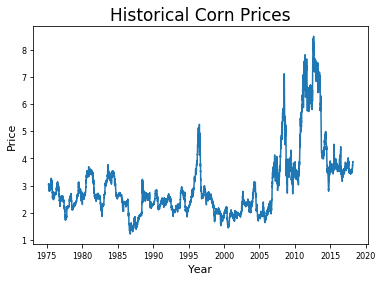

In [10]:
corn = data[data.date < pd.datetime(2018,3,7)]
plt.plot(data.date, data.corn_price)
plt.title('Historical Corn Prices', fontsize=17)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Price', fontsize=11)
plt.tick_params(labelsize=8);

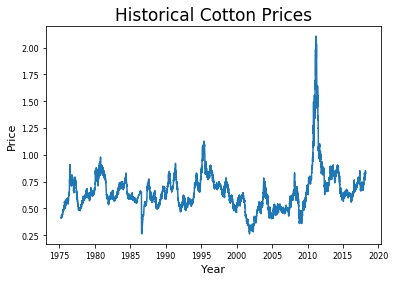

In [11]:
cotton = data[data.date < pd.datetime(2018,3,7)]
plt.plot(data.date, data.cotton_price)
plt.title('Historical Cotton Prices', fontsize=17)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Price', fontsize=11)
plt.tick_params(labelsize=8);

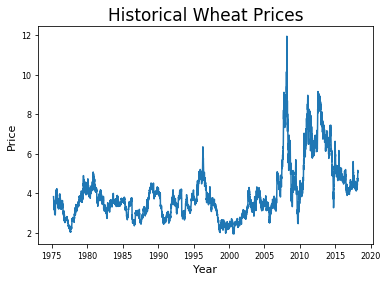

In [12]:
wheat = data[data.date < pd.datetime(2018,3,7)]
plt.plot(data.date, data.wheat_price)
plt.title('Historical Wheat Prices', fontsize=17)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Price', fontsize=11)
plt.tick_params(labelsize=8);

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


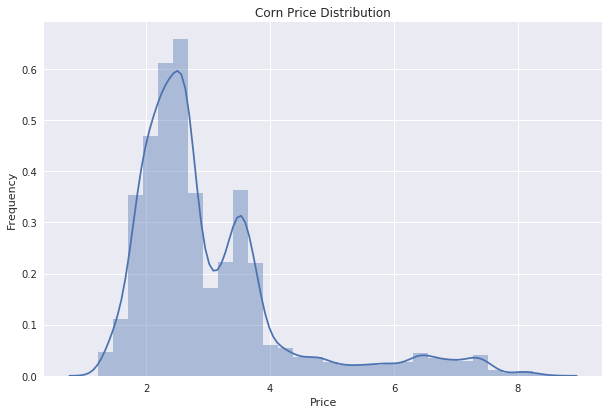

In [13]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 6.5)})

sns.distplot(data.corn_price, bins=30)
plt.title('Corn Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');
plt.show()

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


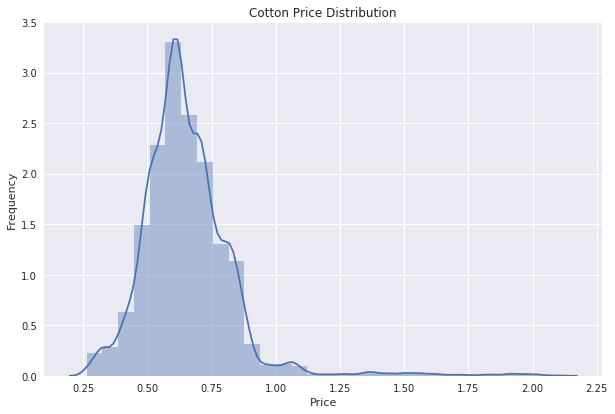

In [14]:
sns.distplot(data.cotton_price, bins=30)
plt.title('Cotton Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');
plt.show()

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


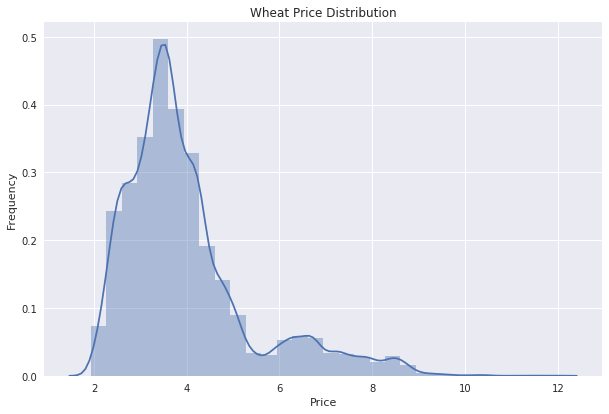

In [15]:
sns.distplot(data.wheat_price, bins=30)
plt.title('Wheat Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');
plt.show()

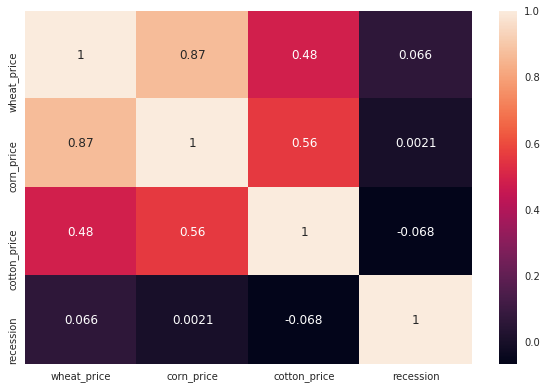

In [16]:
correlation_matrix = data.corr().round(4) 
sns.heatmap(data= correlation_matrix, annot=True)

### Weather Data

In [17]:
# pivot stations into columns, average weather across stations
data2 = pd.read_csv('./main_df.csv', header=0)
data2.head()

,DATE,DEWP,Fog,Hail,MAX,MIN,PRCP,Rain/Drizzle,SLP,Snow/Ice pellets,TEMP,Thunder,Tornado/Funnel cloud,VISIB,WDSP
0,1975-01-01,26.798754,0.486339,0.000000,44.633060,27.100638,0.096371,0.329690,1020.603498,0.273224,35.227322,0.003643,0.0,13.658761,8.176321
1,1975-01-02,21.699458,0.272242,0.000000,41.133452,24.173132,0.075762,0.179715,1021.942063,0.366548,32.081317,0.014235,0.0,14.337089,8.382384
2,1975-01-03,23.128272,0.329787,0.000000,40.896188,23.129300,0.101460,0.338652,1020.194599,0.349291,32.074468,0.003546,0.0,14.615653,7.834220
3,1975-01-04,24.331663,0.250890,0.001779,42.036744,24.544929,0.097979,0.274021,1018.656830,0.231317,32.974911,0.001779,0.0,14.807192,7.388256
4,1975-01-05,22.518032,0.192446,0.000000,42.088309,22.215063,0.056188,0.089928,1019.560352,0.201439,31.966187,0.000000,0.0,15.439308,7.246763


In [18]:
data2['DATE'] = pd.to_datetime(data2.DATE)
print(data2.shape)

(15792, 15)


In [19]:
data2.describe()

,DEWP,Fog,Hail,MAX,MIN,PRCP,Rain/Drizzle,SLP,Snow/Ice pellets,TEMP,Thunder,Tornado/Funnel cloud,VISIB,WDSP
count,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000,15792.000000
mean,41.877475,0.250151,0.001721,65.982522,44.204514,0.083529,0.304380,1016.565954,0.092217,54.497376,0.083409,0.000265,12.183433,7.188552
std,13.303707,0.136819,0.002686,15.308415,14.129165,0.048425,0.108259,3.255619,0.106859,14.809563,0.078904,0.000750,2.956136,1.099459
min,2.074199,0.010239,0.000000,22.790189,6.439717,0.004358,0.019435,1005.146194,0.000000,13.729245,0.000000,0.000000,6.808824,4.191438
25%,30.753118,0.130137,0.000000,52.209223,31.945334,0.046513,0.228319,1014.380419,0.003419,41.293849,0.012048,0.000000,9.459996,6.390990
50%,41.549106,0.244444,0.000000,67.197624,44.243625,0.075336,0.311111,1016.278823,0.044620,55.125171,0.060659,0.000000,11.611755,7.062489
75%,54.806654,0.345955,0.001795,80.664885,57.919497,0.110250,0.382906,1018.492095,0.161535,68.896102,0.140381,0.000000,14.945747,7.881492
max,64.080513,0.749562,0.039655,91.603077,68.593907,0.367380,0.644097,1030.905243,0.551127,79.181880,0.370242,0.006957,20.133380,12.955349


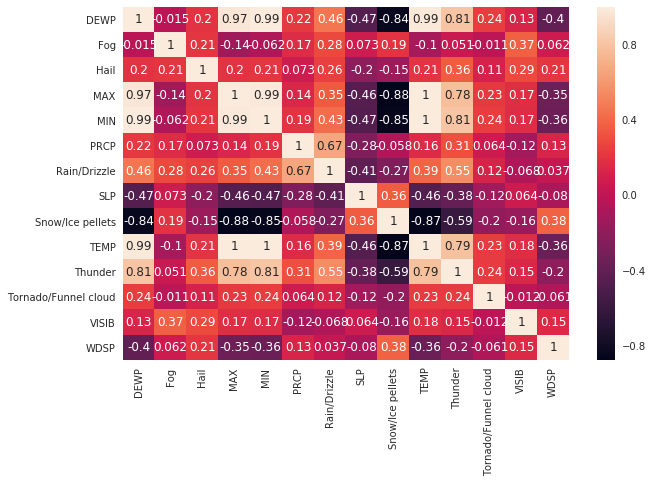

In [20]:
correlation_matrix_1 = data2.corr().round(4) 
sns.heatmap(data= correlation_matrix_1, annot=True)

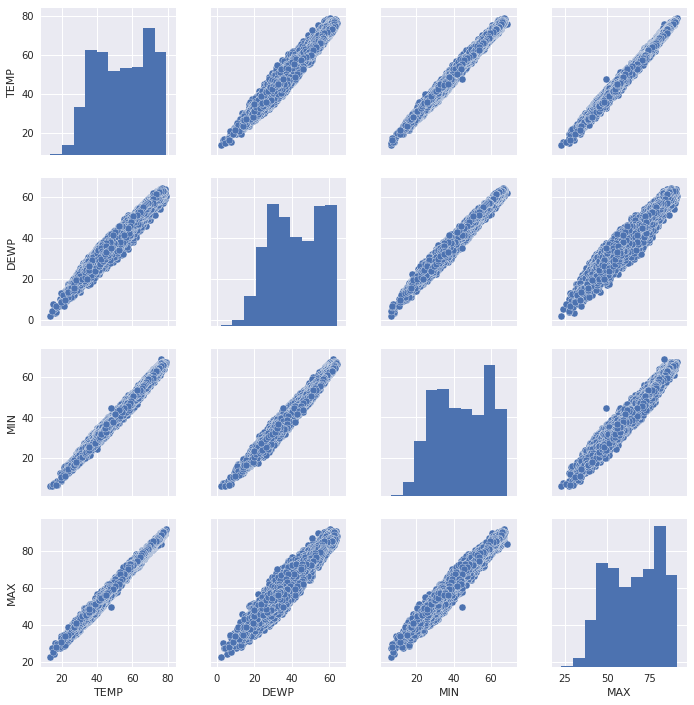

In [21]:
sns.pairplot(vars= data2[['TEMP', 'DEWP', 'MIN', 'MAX']], data= data2)
plt.show()

### Modeling

### Corn

In [22]:
corn = pd.read_csv('./corn-price-data.csv', names=['date', 'price'], header=0)
corn['date'] = pd.to_datetime(corn.date)
data2['DATE'] = pd.to_datetime(data2.DATE)
corn = corn[corn.date < pd.datetime(2018,3,7)]
corn_df = pd.merge(corn, data2, how='left', left_on='date', right_on='DATE')
corn_df.drop('DATE', axis=1, inplace=True)
corn_df.set_index('date', inplace=True)

In [23]:
corn_df.columns

Index(['price', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud',
       'VISIB', 'WDSP'],
      dtype='object')

In [24]:
X = corn_df.dropna()
X.head()

,price,DEWP,Fog,Hail,MAX,MIN,PRCP,Rain/Drizzle,SLP,Snow/Ice pellets,TEMP,Thunder,Tornado/Funnel cloud,VISIB,WDSP
date,,,,,,,,,,,,,,,
1975-01-02,3.4375,21.699458,0.272242,0.000000,41.133452,24.173132,0.075762,0.179715,1021.942063,0.366548,32.081317,0.014235,0.0,14.337089,8.382384
1975-01-03,3.4050,23.128272,0.329787,0.000000,40.896188,23.129300,0.101460,0.338652,1020.194599,0.349291,32.074468,0.003546,0.0,14.615653,7.834220
1975-01-06,3.4775,25.417753,0.345196,0.003559,44.551601,24.910142,0.059527,0.282918,1017.427458,0.313167,34.404270,0.001779,0.0,14.075390,7.163345
1975-01-07,3.3750,29.574578,0.465241,0.000000,46.225312,28.506863,0.096015,0.299465,1015.129889,0.260250,37.113191,0.021390,0.0,12.116546,6.709180
1975-01-08,3.3475,31.356526,0.500888,0.003552,47.084725,30.735169,0.196558,0.440497,1012.940000,0.227353,38.792007,0.083481,0.0,11.764843,7.885346


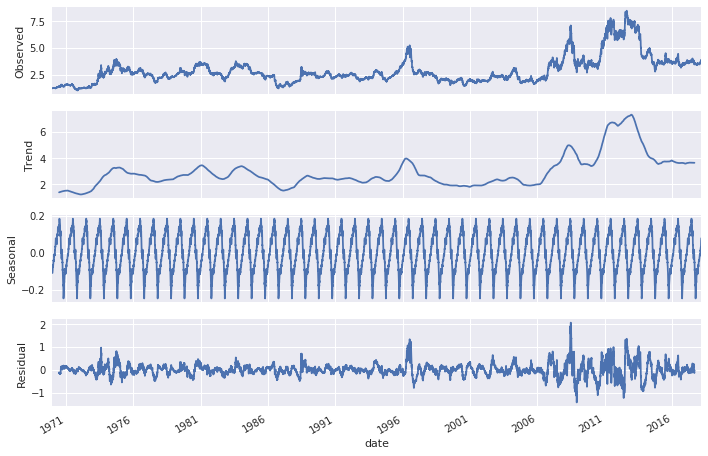

In [25]:
decomposition = seasonal_decompose(corn_df.price, freq=252)
decomposition.plot();

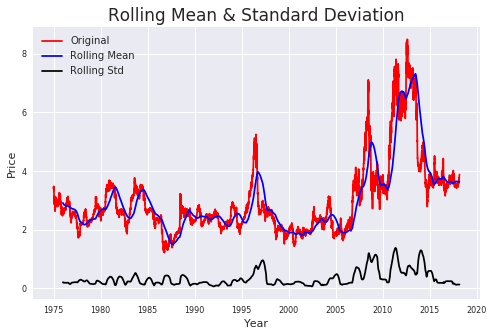

Results of Dickey-Fuller Test:
Test Statistic   -2.800951
p-value           0.058138
dtype: float64


In [26]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=252, center=False).mean()
    rolstd = timeseries.rolling(window=252, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(8, 5))
    orig = plt.plot(timeseries, color='red',label='Original')
    mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=17)
    plt.xlabel('Year', fontsize=11)
    plt.ylabel('Price', fontsize=11)
    plt.tick_params(labelsize=8);
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput)
    
test_stationarity(corn_df.dropna().price) 

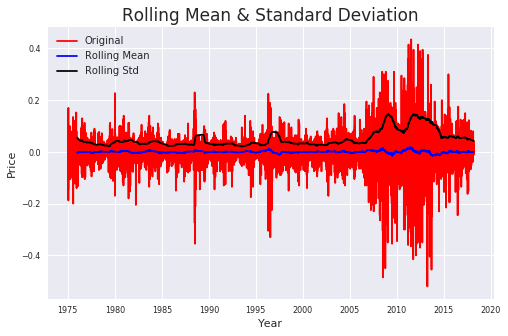

Results of Dickey-Fuller Test:
Test Statistic   -1.469228e+01
p-value           3.036218e-27
dtype: float64


In [27]:
# first difference
corn_df.first_diff = corn_df.dropna().price.diff()

# D-F test on first diff column
test_stationarity(corn_df.first_diff.dropna())

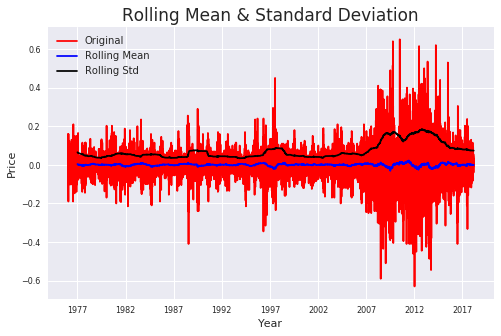

Results of Dickey-Fuller Test:
Test Statistic   -1.451581e+01
p-value           5.627618e-27
dtype: float64


In [28]:
# seasonal + first difference
corn_df.seasonal_first_diff = X.price.diff().diff(252)

# D-F test
test_stationarity(corn_df.seasonal_first_diff.dropna())

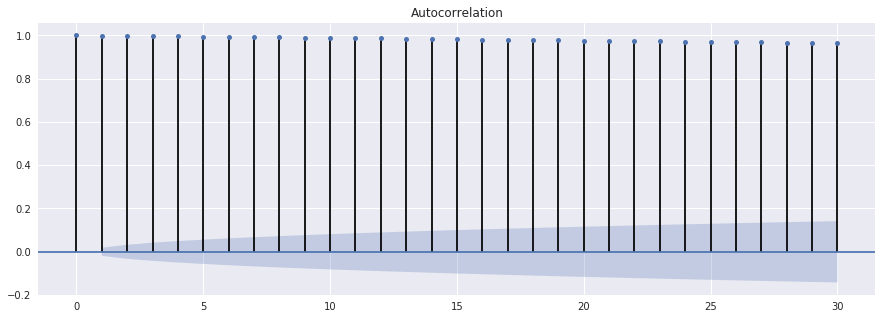

In [29]:
# ACF plot
fig, ax = plt.subplots(figsize=(15,5))
plot_acf(X.price, lags=30, ax=ax);

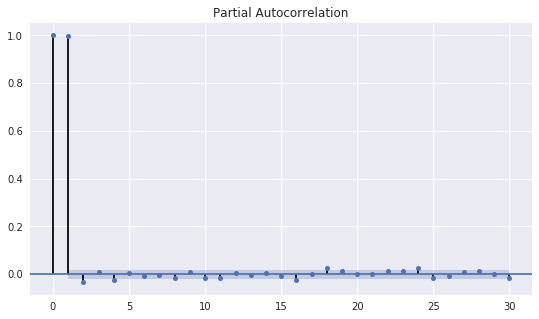

In [30]:
# PACF plot
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(X.price, lags=30, ax=ax);

In [31]:
df = pd.DataFrame(X)
df.dropna().head()

,price,DEWP,Fog,Hail,MAX,MIN,PRCP,Rain/Drizzle,SLP,Snow/Ice pellets,TEMP,Thunder,Tornado/Funnel cloud,VISIB,WDSP
date,,,,,,,,,,,,,,,
1975-01-02,3.4375,21.699458,0.272242,0.000000,41.133452,24.173132,0.075762,0.179715,1021.942063,0.366548,32.081317,0.014235,0.0,14.337089,8.382384
1975-01-03,3.4050,23.128272,0.329787,0.000000,40.896188,23.129300,0.101460,0.338652,1020.194599,0.349291,32.074468,0.003546,0.0,14.615653,7.834220
1975-01-06,3.4775,25.417753,0.345196,0.003559,44.551601,24.910142,0.059527,0.282918,1017.427458,0.313167,34.404270,0.001779,0.0,14.075390,7.163345
1975-01-07,3.3750,29.574578,0.465241,0.000000,46.225312,28.506863,0.096015,0.299465,1015.129889,0.260250,37.113191,0.021390,0.0,12.116546,6.709180
1975-01-08,3.3475,31.356526,0.500888,0.003552,47.084725,30.735169,0.196558,0.440497,1012.940000,0.227353,38.792007,0.083481,0.0,11.764843,7.885346


In [ ]:
def model_eval(comm, results, corn_df):
    # plot residuals
    plt.plot(results.resid[5:])
    plt.title('Price Residuals', fontsize=10)
    plt.xlabel('Year', fontsize=7)
    plt.show()

    # list of 15 day forecasts
    x = 9001      
    forward_15 = []
    for i in range(len(corn_df) - 9015):
        pred = results.predict(start=x, end=x+14, dynamic=True)
        forward_15.append(pred[14])
        x += 1

    # 15 day preds vs actual
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(X.price.index[9015:], X.price.price[9015:], lw=2, color='grey', ls='dashed',label='Actual')
    ax.plot(X.price.index[9015:], forward_15, lw=2, color='darkred',label='Pred')
    plt.title('Fifteen Day Predictions vs Actual', fontsize=30)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price', fontsize=18)
    plt.tick_params(labelsize=12);
    plt.legend()
    plt.show()
    
    # 15 day r2 score
    print('15-day forecast r2 score:', r2_score(X.price[9015:], forward_15))

In [ ]:
# corn model
p = 1 # number of lagged values
d = 1 # number of diffs in lag
q = 5 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days in season

endog=df.price['1975-01-02':'1980-01-02']
exog = df.TEMP['1975-01-02':'1980-01-02']
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog, exog, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
results.summary()

In [ ]:
model_eval('Corn', results, corn_df.dropna())

In [132]:
# function for model profit analysis
# returns dates and corresponding money totals
def profit_loss(dollars, start, forward_15, corn_df):
    i = start
    in_market = False
    shares = 0
    money = dollars
    dates= [9000+i]
    tracker = [dollars]
    while i < len(forward_15):
        pred_price = forward_15[i]
        current_price = corn_df.dropna().price[9000+i]
        if current_price < pred_price and in_market==False:
            entry = current_price
            shares = money / entry
            in_market=True

        if current_price > pred_price and in_market==True:
            exit = current_price
            money = shares * exit
            in_market=False
            dates.append(i+9000)
            tracker.append(money)
        i += 15
    return dates, tracker

In [133]:
# function for model profit analysis
# returns percent gain/loss
def profit_loss_perc(dollars, start, forward_15, corn_df):
    i = start
    in_market = False
    shares = 0
    money = dollars
    
    while i < len(forward_15):
        pred_price = forward_15[i]
        current_price = corn_df.dropna().price[9000+i]
        if current_price < pred_price and in_market==False:
            entry = current_price
            shares = money / entry
            in_market=True

        if current_price > pred_price and in_market==True:
            exit = current_price
            money = shares * exit
            in_market=False
        i += 15
    return (money / dollars) / (current_price / corn_df.dropna().price[9000+start])

In [134]:
# list of 15 day forecasts
x = 9001      
forward_15 = []
for i in range(len(corn_df) - 9015):
    pred = results.predict(start=x, end=x+14, dynamic=True)
    forward_15.append(pred[14])
    x += 1

NameError: name 'results' is not defined

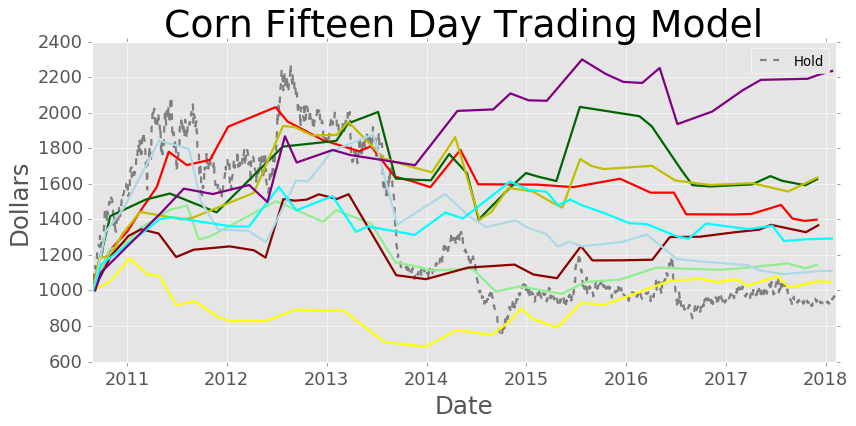

In [439]:
# corn $1000 profit vs. holding
dates, tracker = profit_loss(1000, 0, forward_15, corn_df)

color=['r', 'lightgreen', 'darkgreen', 'y', 'darkred', 'yellow', 'lightblue', 'cyan', 'purple', 'orange', 'b', 'indigo', 'violet','gold','darkblue']
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(corn_df.index[9000:len(corn_df) - 20], corn_df.dropna().price[9000:len(corn_df) - 20]*(1000/corn_df.dropna().price[9000]), lw=2, color='grey', ls='dashed',label='Hold')
for x in range(9):
    dates, tracker = profit_loss(1000, x, forward_15, corn_df)
    ax.plot(corn_df.index[dates], tracker, lw=2, c=color[x])
plt.title('Corn Fifteen Day Trading Model', fontsize=34)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Dollars', fontsize=22)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

In [307]:
profit_loss_perc(100, 0, forward_15, corn_df)

1.4464693021271176

In [311]:
np.mean([profit_loss_perc(100, n, forward_15, corn_df) for n in range(15)])

1.605556466167472

### Cotton

In [ ]:
cotton = pd.read_csv('./cotton-price-data.csv', names=['date', 'price'], header=0)
cotton['date'] = pd.to_datetime(cotton.date)
data2['DATE'] = pd.to_datetime(data2.DATE)
cotton = cotton[cotton.date < pd.datetime(2018,3,7)]
cotton_df = pd.merge(cotton, data2, how='left', left_on='date', right_on='DATE')
cotton_df.drop('DATE', axis=1, inplace=True)
cotton_df.set_index('date', inplace=True)

In [ ]:
cotton_df.columns

In [ ]:
Y = cotton_df.dropna()
Y.head()

In [ ]:
decomposition = seasonal_decompose(cotton_df.price, freq=252)
decomposition.plot();

In [ ]:
# cotton D-F test
test_stationarity(cotton_df.dropna().price)

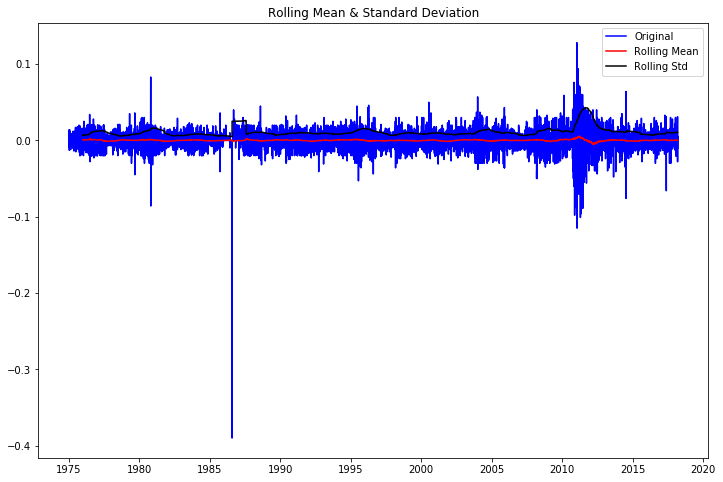

Results of Dickey-Fuller Test:
Test Statistic   -1.432665e+01
p-value           1.117733e-26
dtype: float64


In [33]:
# cotton first difference
cotton_df['first_diff'] = cotton_df.dropna().price.diff()

# D-F test on first diff column
test_stationarity(cotton_df.first_diff.dropna())

In [ ]:
# seasonal + first difference
cotton_df.seasonal_first_diff = Y.price.diff().diff(252)

# D-F test
test_stationarity(cotton_df.seasonal_first_diff.dropna())

In [434]:
# cotton model
main_df = pd.read_csv('.//main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
cotton = cotton[cotton.date > pd.datetime(1974,12,31)]
final_df = pd.merge(cotton, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']


p = 1 # lagged values
d = 1 # diffs
q = 5 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days preceding

exog = final_df.drop('price', axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10899
Model:               SARIMAX(1, 1, 5)   Log Likelihood               32442.099
Date:                Tue, 10 Apr 2018   AIC                         -64838.197
Time:                        01:04:59   BIC                         -64670.380
Sample:                    01-02-1975   HQIC                        -64781.634
                         - 03-07-2018                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.931e-16   2.29e-12   8.43e-05      1.000   -4.49e-12    4.49e-12
recession               -0.0028      0.003     -0.840      0.401      -0.009       0.004
DEWP                 -7.189e-05      0.000     -0.491      0.623      -0.000       0.000
Fog                      0.0014      0.003      0.417      0.677      -0.005       0.008
Hail                    -0.0071      0.048     -0.148      0.882      -0.101       0.086
MAX                   7.249e-05      0.000      0.368      0.713      -0.000       0.000
MIN                      0.0002      0.000      0.949      0.343      -0.000       0.001
PRCP                    -0.0014      0.003     -0.491      0.623      -0.007       0.004
Rain/Drizzle            -0.0032      0.002     -1.491      0.136      -0.007       0.001
SLP                  -1.076e-05   5.92e-05     -0.182      0.856      -0.000       0.000
Snow/Ice pellets         0.0010      0.003      0.317      0.751      -0.005       0.007
TEMP                    -0.0001      0.000     -0.318      0.750      -0.001       0.001
Thunder                 -0.0030      0.004     -0.804      0.421      -0.010       0.004
Tornado/Funnel cloud    -0.1359      0.123     -1.105      0.269      -0.377       0.105
VISIB                   -0.0001      0.000     -0.433      0.665      -0.001       0.000
WDSP                 -4.407e-05      0.000     -0.256      0.798      -0.000       0.000
ar.L1                   -0.2350      0.234     -1.005      0.315      -0.693       0.223
ma.L1                    0.2800      0.234      1.196      0.232      -0.179       0.739
ma.L2                    0.0124      0.011      1.140      0.254      -0.009       0.034
ma.L3                   -0.0141      0.005     -2.975      0.003      -0.023      -0.005
ma.L4                    0.0092      0.006      1.613      0.107      -0.002       0.020
ma.L5                    0.0227      0.005      4.291      0.000       0.012       0.033
sigma2                   0.0002   3.45e-07    441.397      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      154.54   Jarque-Bera (JB):           4525003.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -3.05
Prob(H) (two-sided):                  0.00   Kurtosis:                       102.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+25. Standard errors may be unstable.
"""

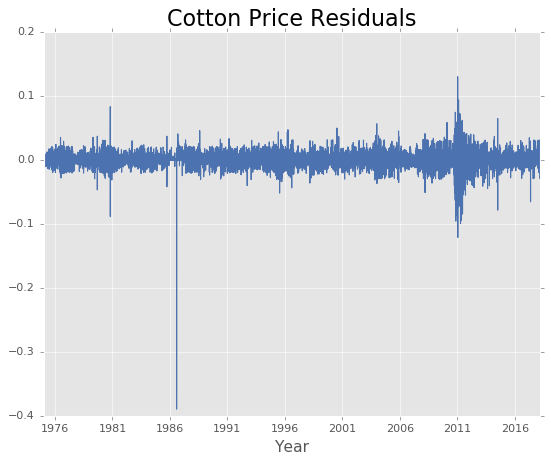

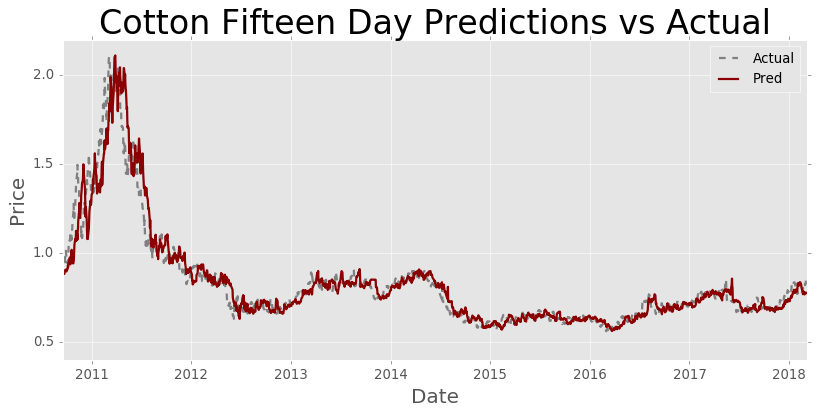

15-day forecast r2 score: 0.9137357202275361


In [427]:
model_eval('Cotton', results, final_df)

In [435]:
# list of 15 day forecasts
x = 9001      
forward_15 = []
for i in range(len(final_df) - 9015):
    pred = results.predict(start=x, end=x+14, dynamic=True)
    forward_15.append(pred[14])
    x += 1

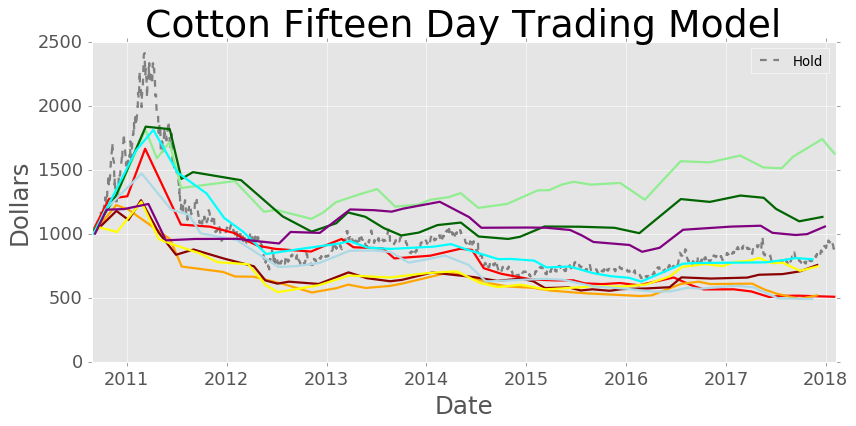

In [436]:
# cotton $1000 profit vs. holding
dates, tracker = profit_loss(1000, 0, forward_15, final_df)

color=['r', 'lightgreen', 'darkgreen', 'orange', 'darkred', 'yellow', 'lightblue', 'cyan', 'purple', 'orange', 'b', 'indigo', 'violet','gold','darkblue']
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(final_df.index[9000:len(final_df) - 20], final_df.price[9000:len(final_df) - 20]*(1000/final_df.price[9000]), lw=2, color='grey', ls='dashed',label='Hold')
for x in range(9):
    dates, tracker = profit_loss(1000, x, forward_15, final_df)
    ax.plot(final_df.index[dates], tracker, lw=2, c=color[x])
plt.title('Cotton Fifteen Day Trading Model', fontsize=34)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Dollars', fontsize=22)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

In [314]:
np.mean([profit_loss_perc(100, n, forward_15, final_df) for n in range(15)])

1.1611932802634404

### Wheat

In [ ]:
wheat = pd.read_csv('./corn-price-data.csv', names=['date', 'price'], header=0)
wheat['date'] = pd.to_datetime(corn.date)
data2['DATE'] = pd.to_datetime(data2.DATE)
wheat = wheat[wheat.date < pd.datetime(2018,3,7)]
wheat_df = pd.merge(wheat, data2, how='left', left_on='date', right_on='DATE')
wheat_df.drop('DATE', axis=1, inplace=True)
wheat_df.set_index('date', inplace=True)

In [1]:
wheat_df.columns

NameError: name 'wheat_df' is not defined

In [ ]:
Z = wheat_df.dropna()
Z.head()

In [ ]:
decomposition = seasonal_decompose(wheat_df.price, freq=252)
decomposition.plot();

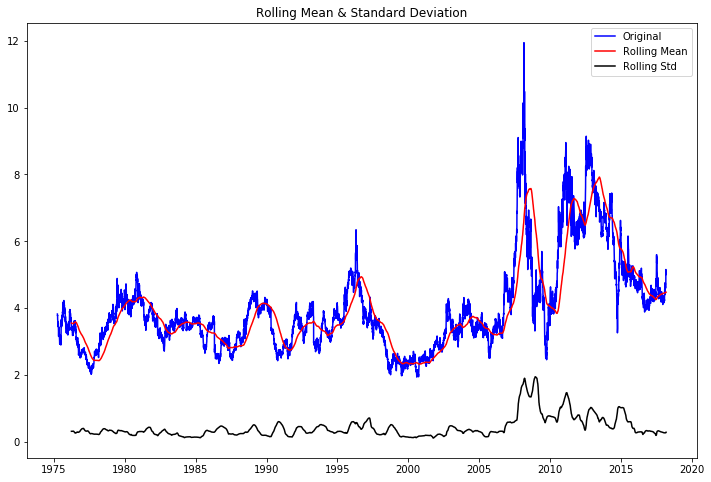

Results of Dickey-Fuller Test:
Test Statistic   -3.061788
p-value           0.029513
dtype: float64


In [20]:
# wheat D-F test
test_stationarity(wheat_df.price)

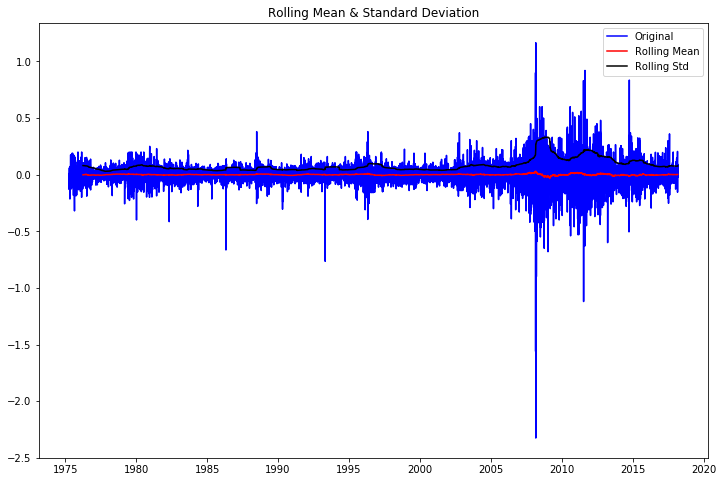

Results of Dickey-Fuller Test:
Test Statistic   -20.761168
p-value            0.000000
dtype: float64


In [21]:
# wheat first difference
wheat_df['first_diff'] = wheat_df.dropna().price.diff()

# D-F test on first diff column
test_stationarity(wheat_df.first_diff.dropna())

In [ ]:
# seasonal + first difference
wheat_df.seasonal_first_diff = Z.price.diff().diff(252)

# D-F test
test_stationarity(wheat_df.seasonal_first_diff.dropna())

In [428]:
# wheat model
main_df = pd.read_csv('./main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
final_df = pd.merge(wheat, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']



p = 1 # lagged values
d = 1 # diffs
q = 5 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days preceding

exog = final_df.drop('price', axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10834
Model:               SARIMAX(1, 1, 5)   Log Likelihood                9913.356
Date:                Tue, 10 Apr 2018   AIC                         -19780.711
Time:                        00:51:09   BIC                         -19613.031
Sample:                    04-04-1975   HQIC                        -19724.178
                         - 03-07-2018                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.797e-12        nan        nan        nan         nan         nan
recession                0.0517      0.019      2.694      0.007       0.014       0.089
DEWP                    -0.0015      0.001     -1.290      0.197      -0.004       0.001
Fog                      0.0305      0.029      1.048      0.295      -0.027       0.087
Hail                     0.0225      0.444      0.051      0.960      -0.848       0.893
MAX                     -0.0008      0.002     -0.418      0.676      -0.004       0.003
MIN                     -0.0010      0.002     -0.501      0.616      -0.005       0.003
PRCP                    -0.0757      0.022     -3.375      0.001      -0.120      -0.032
Rain/Drizzle            -0.0106      0.018     -0.604      0.546      -0.045       0.024
SLP                     -0.0002      0.000     -0.420      0.675      -0.001       0.001
Snow/Ice pellets        -0.0548      0.028     -1.930      0.054      -0.111       0.001
TEMP                     0.0026      0.003      0.830      0.406      -0.004       0.009
Thunder                  0.0226      0.029      0.790      0.429      -0.034       0.079
Tornado/Funnel cloud     0.4136      0.923      0.448      0.654      -1.396       2.223
VISIB                 7.011e-05      0.003      0.023      0.982      -0.006       0.006
WDSP                     0.0026      0.001      1.944      0.052   -2.19e-05       0.005
ar.L1                   -0.7619      0.722     -1.056      0.291      -2.177       0.653
ma.L1                    1.2691      1.325      0.958      0.338      -1.328       3.866
ma.L2                   -0.1147      0.051     -2.244      0.025      -0.215      -0.015
ma.L3                   -0.0395      0.076     -0.520      0.603      -0.189       0.110
ma.L4                   -0.0066      0.038     -0.174      0.862      -0.081       0.068
ma.L5                   -0.0491      0.054     -0.905      0.365      -0.155       0.057
sigma2                   0.0054      0.011      0.508      0.612      -0.015       0.026
===================================================================================
Ljung-Box (Q):                      192.98   Jarque-Bera (JB):            787973.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.45   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+24. Standard errors may be unstable.
"""

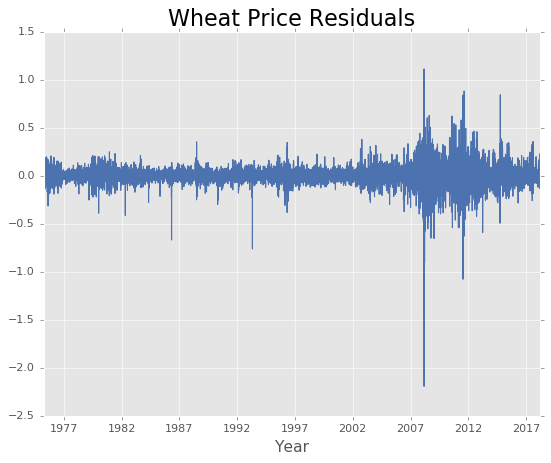

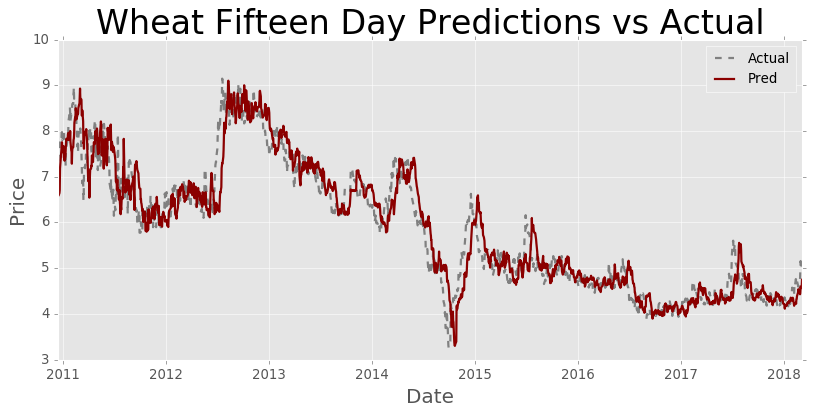

15-day forecast r2 score: 0.8930246611019044


In [429]:
model_eval('Wheat', results, final_df)

In [430]:
# list of 15 day forecasts
x = 9001      
forward_15 = []
for i in range(len(final_df) - 9015):
    pred = results.predict(start=x, end=x+14, dynamic=True)
    forward_15.append(pred[14])
    x += 1

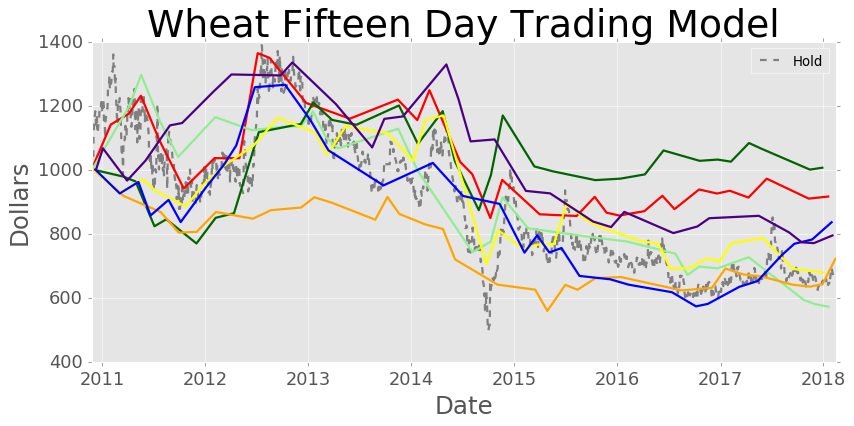

In [432]:
# wheat $1000 profit vs. holding
dates, tracker = profit_loss(1000, 0, forward_15, final_df)
nums = [0,1,2,3,5,8,11]
color=['r', 'lightgreen', 'darkgreen', 'orange', 'darkred', 'yellow', 'lightblue', 'cyan', 'blue', 'orange', 'b', 'indigo', 'violet','gold','darkblue']
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(final_df.index[9000:len(final_df) - 20], final_df.price[9000:len(final_df) - 20]*(1000/final_df.price[9000]), lw=2, color='grey', ls='dashed',label='Hold')
for x in nums:
    dates, tracker = profit_loss(1000, x, forward_15, final_df)
    ax.plot(final_df.index[dates], tracker, lw=2, c=color[x])
plt.title('Wheat Fifteen Day Trading Model', fontsize=34)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Dollars', fontsize=22)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

In [317]:
np.mean([profit_loss_perc(100, n, forward_15, final_df) for n in range(15)])

1.2618396355666124

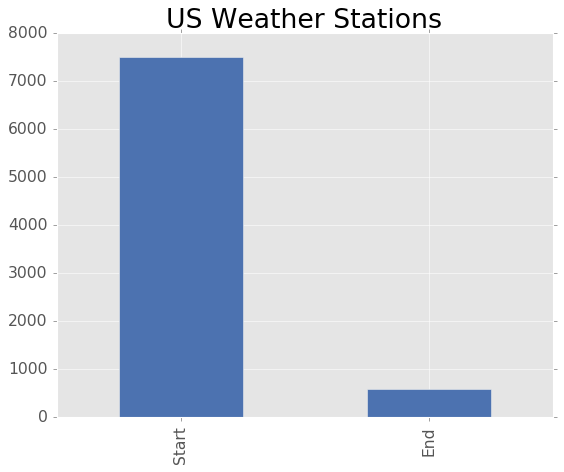

In [397]:
plt.style.use("seaborn-deep")

df = pd.DataFrame({'time': ['Start', 'End'],'num': [7514, 588]})

df.plot(kind='bar', x='time', y='num', legend=False)
plt.title('US Weather Stations', fontsize=24)
plt.xlabel('')
plt.tick_params(labelsize=14);

In [181]:
stat_co = [x for x in df.STN.value_counts()]

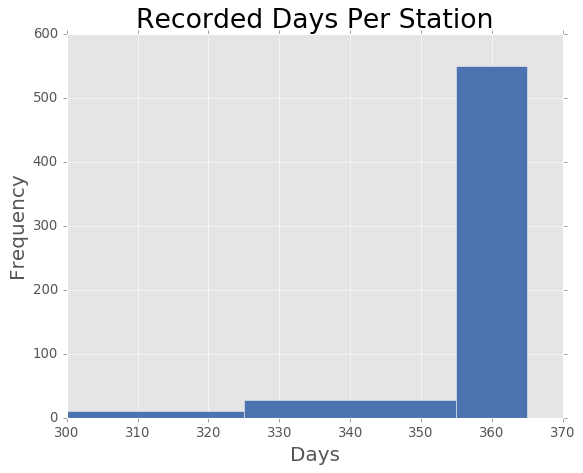

In [410]:
# how many days of data does each station have
x = []
for i in range(10):
    x.append(310)
for i in range(28):
    x.append(340)
for i in range(550):
    x.append(360)

plt.hist(x, bins=[300,325,355,365])
plt.title('Recorded Days Per Station', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(labelsize=12);